In [1]:
import pickle
import pandas as pd
import pandas_profiling
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
palette = sns.color_palette("pastel")

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostRegressor 
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, r2_score, mean_squared_error, classification_report, make_scorer
from sklearn.linear_model import LogisticRegression


import statsmodels.api as sm

pd.set_option('display.max_columns', 500)
pd.options.display.max_rows = 500

In [35]:
# read in data
sentiment_df = pd.read_pickle('data/twitter/cities_sentiment_data.pkl')
census_df = pd.read_pickle('data/census/census_data.pkl')

In [36]:
# subset sentiment data
sentiment_df2 = sentiment_df[["closest_city",
         "closest_state",
#          "negative",
#          "neutral",
#          "positive",
#          "Population2010",
#          "ACCESS2_AdjPrev",
#          "ARTHRITIS_AdjPrev",
#          "BINGE_AdjPrev",
#          "BPHIGH_AdjPrev",
#          "BPMED_AdjPrev",
#          "CANCER_AdjPrev",
#          "CASTHMA_AdjPrev",
#          "CHD_AdjPrev",
#          "CHECKUP_AdjPrev",
#          "CHOLSCREEN_AdjPrev",
#          "COLON_SCREEN_AdjPrev",
#          "COPD_AdjPrev",
#          "COREM_AdjPrev",
#          "COREW_AdjPrev",
#          "CSMOKING_AdjPrev",
#          "DENTAL_AdjPrev",
#          "DIABETES_AdjPrev",
#          "HIGHCHOL_AdjPrev",
#          "KIDNEY_AdjPrev",
#          "LPA_AdjPrev",
#          "MAMMOUSE_AdjPrev",
#          "MHLTH_AdjPrev",
         "OBESITY_cut",
#          "PAPTEST_AdjPrev",
#          "PHLTH_AdjPrev",
#          "SLEEP_AdjPrev",
#          "STROKE_AdjPrev",
#          "TEETHLOST_AdjPrev"
         ]]

In [37]:
# merge sentiment to cdc
df = pd.merge(sentiment_df2, 
                       census_df, 
                       left_on=('closest_city','closest_state'), 
                       right_on=('closest_city','closest_state'), 
                       indicator = True)  

In [38]:
df.head()

,closest_city,closest_state,OBESITY_cut,"Population estimates, July 1, 2018, (V2018)","Population estimates base, April 1, 2010, (V2018)","Population, percent change - April 1, 2010 (estimates base) to July 1, 2018, (V2018)","Population, Census, April 1, 2010","Persons under 5 years, percent","Persons under 18 years, percent","Persons 65 years and over, percent","Female persons, percent","White alone, percent","Black or African American alone, percent","American Indian and Alaska Native alone, percent","Asian alone, percent","Native Hawaiian and Other Pacific Islander alone, percent","Two or More Races, percent","Hispanic or Latino, percent","White alone, not Hispanic or Latino, percent","Veterans, 2013-2017","Foreign born persons, percent, 2013-2017","Owner-occupied housing unit rate, 2013-2017","Median value of owner-occupied housing units, 2013-2017","Median selected monthly owner costs -with a mortgage, 2013-2017","Median selected monthly owner costs -without a mortgage, 2013-2017","Median gross rent, 2013-2017","Households, 2013-2017","Persons per household, 2013-2017","Living in same house 1 year ago, percent of persons age 1 year+, 2013-2017","Language other than English spoken at home, percent of persons age 5 years+, 2013-2017","Households with a computer, percent, 2013-2017","Households with a broadband Internet subscription, percent, 2013-2017","High school graduate or higher, percent of persons age 25 years+, 2013-2017","Bachelor's degree or higher, percent of persons age 25 years+, 2013-2017","With a disability, under age 65 years, percent, 2013-2017","Persons without health insurance, under age 65 years, percent","In civilian labor force, total, percent of population age 16 years+, 2013-2017","In civilian labor force, female, percent of population age 16 years+, 2013-2017","Total accommodation and food services sales, 2012 (1,000)","Total health care and social assistance receipts/revenue, 2012 (1,000)","Total manufacturers shipments, 2012 (1,000)","Total merchant wholesaler sales, 2012 (1,000)","Total retail sales, 2012 (1,000)","Total retail sales per capita, 2012","Mean travel time to work (minutes), workers age 16 years+, 2013-2017","Median household income (in 2017 dollars), 2013-2017","Per capita income in past 12 months (in 2017 dollars), 2013-2017","Persons in poverty, percent","All firms, 2012","Men-owned firms, 2012","Women-owned firms, 2012","Minority-owned firms, 2012","Nonminority-owned firms, 2012","Veteran-owned firms, 2012","Nonveteran-owned firms, 2012","Population per square mile, 2010","Land area in square miles, 2010",_merge
0,Abilene,TX,high,122999.0,117512.0,4.7,117063.0,7.3,23.100000,12.600000,48.299999,73.099998,10.1,1.1,2.100000,0.0,3.3,26.799999,58.799999,9310.0,6.100000,54.500000,106800.0,1166.0,426.0,846.0,42287.0,2.58,73.300003,19.000000,86.800003,71.699997,85.000000,22.100000,11.5,17.5,57.500000,58.700001,0.0,0.0,898344.0,1861865.0,2087352.0,17557.0,15.7,46093.0,22819.0,17.700001,9823.0,5551.0,2991.0,2212.0,7035.0,1262.0,7685.0,1096.199951,106.790001,both
1,Akron,OH,high,198006.0,199135.0,-0.6,199110.0,6.4,21.200001,14.200000,51.900002,60.299999,30.5,0.3,4.000000,0.0,4.3,2.400000,58.799999,12125.0,5.900000,51.000000,80100.0,981.0,403.0,713.0,84443.0,2.29,85.800003,7.200000,81.199997,70.500000,86.500000,20.799999,11.8,11.8,62.299999,59.299999,257415.0,2883921.0,3477813.0,1695828.0,1906638.0,9603.0,21.5,36223.0,22416.0,24.100000,16308.0,8724.0,6308.0,4488.0,11112.0,1546.0,13855.0,3209.699951,62.029999,both
2,Albuquerque,NM,medium,560218.0,546191.0,2.6,545852.0,6.3,23.000000,14.200000,51.200001,73.599998,3.3,4.4,2.700000,0.1,4.3,48.500000,40.000000,38908.0,9.900000,59.799999,188500.0,1324.0,416.0,833.0,221119.0,2.49,83.599998,28.700001,87.199997,76.300003,89.500000,34.299999,9.5,12.1,63.799999,59.500000,1578983.0,5183979.0,0.0,4784857.0,9067367.0,16325.0,21.2,49878.0,28229.0,18.200001,42272.0,20208.0,16129.0,16511.0,23116.0,4147.0,35096.0,2907.600098,187.729996,both
3,Alexandria,VA,low,

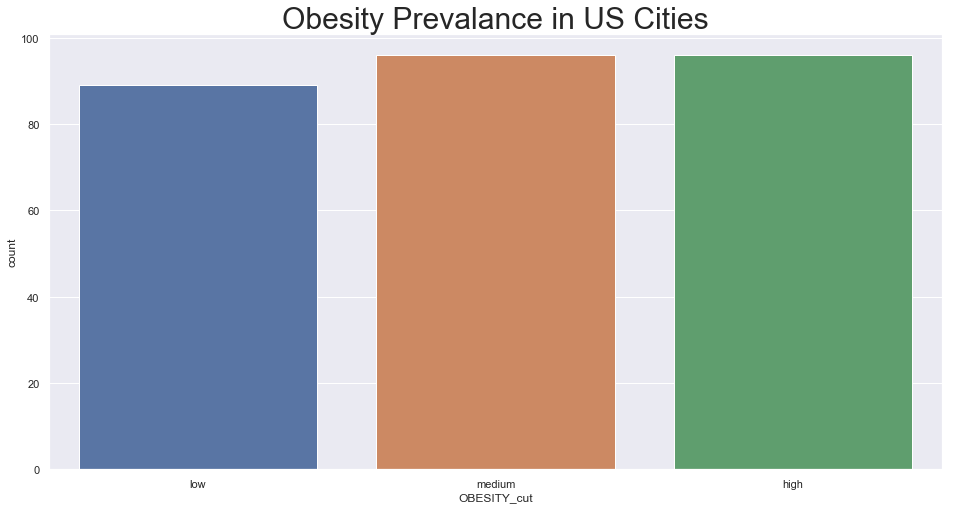

In [39]:
#See result of binning
sns.set_context(font_scale=20) 
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize = (16,8))
ax = sns.countplot(df["OBESITY_cut"]);
ax.axes.set_title("Obesity Prevalance in US Cities",fontsize=30);

In [40]:
len(df)

281

# Modeling

In [41]:
# Feature Engineering
X = df.drop(['closest_city','closest_state', '_merge',
            'OBESITY_cut',
             "All firms, 2012", 
             "Households with a broadband Internet subscription, percent, 2013-2017",
             "Households, 2013-2017",
             "Language other than English spoken at home, percent of persons age 5 years+, 2013-2017",
             "Median selected monthly owner costs -with a mortgage, 2013-2017",
             "Women-owned firms, 2012",
             "Nonminority-owned firms, 2012",
             "Nonveteran-owned firms, 2012",
             "Population estimates base, April 1, 2010,  (V2018)",
             "Population, Census, April 1, 2010",
             "Population estimates base, April 1, 2010,  (V2018)",
             "Total health care and social assistance receipts/revenue, 2012 (1,000)",
             "Total manufacturers shipments, 2012 (1,000)",
             "Total merchant wholesaler sales, 2012 (1,000)",
             "Total retail sales, 2012 (1,000)",
             "Veteran-owned firms, 2012",
             "Total accommodation and food services sales, 2012 (1,000)",
             "Native Hawaiian and Other Pacific Islander alone, percent",
             "Men-owned firms, 2012",
             "Population estimates, July 1, 2018,  (V2018)"   
             ], axis = 1)
y = df["OBESITY_cut"]

In [42]:
X["Persons per household, 2013-2017"] = X["Persons per household, 2013-2017"].astype('float32')
X["Mean travel time to work (minutes), workers age 16 years+, 2013-2017"] = X["Mean travel time to work (minutes), workers age 16 years+, 2013-2017"].astype('float32')
X = pd.DataFrame(X).fillna(0)


In [43]:
#futher reduce features
X = X[[
    "Population, percent change - April 1, 2010 (estimates base) to July 1, 2018,  (V2018)",
    "Persons 65 years and over, percent",
    "White alone, percent",
    "Black or African American alone, percent",
    "Asian alone, percent",
    "Hispanic or Latino, percent",
    "Veterans, 2013-2017",
    "Median gross rent, 2013-2017",
    "Bachelor's degree or higher, percent of persons age 25 years+, 2013-2017",
    "Persons  without health insurance, under age 65 years, percent",
    "In civilian labor force, total, percent of population age 16 years+, 2013-2017",
    "Mean travel time to work (minutes), workers age 16 years+, 2013-2017",
    "Per capita income in past 12 months (in 2017 dollars), 2013-2017",
    "Persons in poverty, percent"
    ]]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,
                                                        random_state=4)

In [45]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((196, 14), (85, 14), (196,), (85,))

## Logistic Regression

In [46]:
logistic = LogisticRegression(penalty='l2',
                            dual=False,
                            tol=0.0001,
                            C=1.0,
                            fit_intercept=True,
                            intercept_scaling=1,
                            class_weight=None,
                            random_state=None,
                            solver='warn',
                            max_iter=100,
                            multi_class='warn',
                            verbose=0,
                            warm_start=False, n_jobs=None, l1_ratio=None)
logistic.fit(X_train, y_train)
logistic_pred = logistic.predict(X_test)

print(classification_report(y_test, logistic_pred))

              precision    recall  f1-score   support

        high       0.80      0.75      0.77        32
         low       0.84      0.81      0.82        26
      medium       0.57      0.63      0.60        27

    accuracy                           0.73        85
   macro avg       0.74      0.73      0.73        85
weighted avg       0.74      0.73      0.73        85



/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


## Random Forest

In [47]:
rf = RandomForestClassifier(n_estimators='warn',
                            criterion='gini',
                            max_depth=None,
                            min_samples_split=2,
                            min_samples_leaf=1,
                            min_weight_fraction_leaf=0.0,
                            max_features='auto',
                            max_leaf_nodes=None,
                            min_impurity_decrease=0.0,
                            min_impurity_split=None,
                            bootstrap=True,
                            oob_score=False,
                            n_jobs=None,
                            random_state=None,
                            verbose=0,
                            warm_start=False,
                            class_weight=None)
rf.fit(X_train, y_train)
importances = rf.feature_importances_
RF_pred = rf.predict(X_test)
print(classification_report(y_test, RF_pred))

              precision    recall  f1-score   support

        high       0.77      0.53      0.63        32
         low       0.74      0.77      0.75        26
      medium       0.44      0.59      0.51        27

    accuracy                           0.62        85
   macro avg       0.65      0.63      0.63        85
weighted avg       0.66      0.62      0.63        85



/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Text(0.5, 1.0, 'Feature Importance')

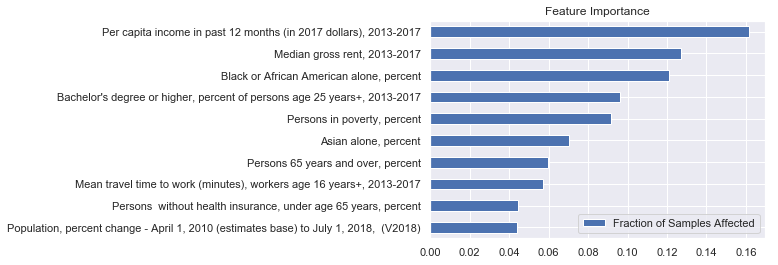

In [57]:
importances = rf.feature_importances_
feat_scores = pd.DataFrame({'Fraction of Samples Affected' : rf.feature_importances_},
                           index=X.columns)
feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected')
feat_scores_topten = feat_scores.tail(10)
feat_scores_topten.plot(kind='barh')
plt.title("Feature Importance")
# plt.savefig('images/Feature_Importance')

## Gradient Boosting

In [48]:
gb = GradientBoostingClassifier(loss='deviance', 
                           learning_rate=0.001, 
                           n_estimators=100, 
                           subsample=1.0, 
                           criterion='friedman_mse', 
                           min_samples_split=4, 
                           min_samples_leaf=1, 
                           min_weight_fraction_leaf=0.0, 
                           max_depth=1, 
                           min_impurity_decrease=0.0, 
                           min_impurity_split=None, 
                           init=None, 
                           random_state=None, 
                           max_features=None, 
                           verbose=0, 
                           max_leaf_nodes=None, 
                           warm_start=False, 
                           presort='auto', 
                           validation_fraction=0.1, 
                           n_iter_no_change=None, 
                           tol=0.0001)

gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)
print(classification_report(y_test, gb_pred))

              precision    recall  f1-score   support

        high       0.70      0.59      0.64        32
         low       0.76      0.50      0.60        26
      medium       0.39      0.59      0.47        27

    accuracy                           0.56        85
   macro avg       0.62      0.56      0.57        85
weighted avg       0.62      0.56      0.58        85



In [49]:
importances = gb.feature_importances_
feat_scores = pd.DataFrame({'Fraction of Samples Affected' : gb.feature_importances_},
                           index=X.columns)
feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected')
feat_scores_topten = feat_scores.tail(10)
feat_scores_topten.plot(kind='barh')
plt.title("Feature Importance")
# plt.savefig('images/Feature_Importance')

Text(0.5, 1.0, 'Feature Importance')

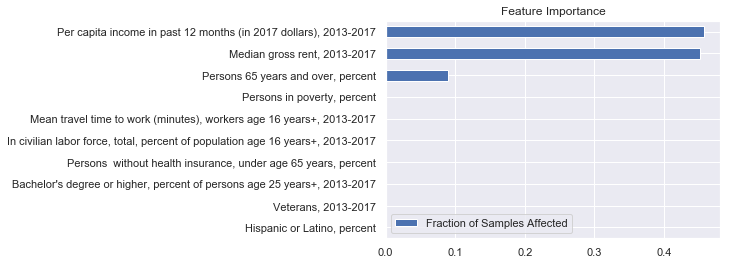

partial dependence. compares error when remove feature to see which features are most impactful. do chi-sq on sentiment and outcome. Ask Lori! Do a confusion matrix and ROC curves.

### can't do a chi-sq because sentiment isn't categorical

# Do models with sentiment



In [53]:
# subset sentiment data
sentiment_df2 = sentiment_df[["closest_city",
         "closest_state",
          "negative",
#           "neutral",
          "positive",
#          "Population2010",
#          "ACCESS2_AdjPrev",
#          "ARTHRITIS_AdjPrev",
#          "BINGE_AdjPrev",
#          "BPHIGH_AdjPrev",
#          "BPMED_AdjPrev",
#          "CANCER_AdjPrev",
#          "CASTHMA_AdjPrev",
#          "CHD_AdjPrev",
#          "CHECKUP_AdjPrev",
#          "CHOLSCREEN_AdjPrev",
#          "COLON_SCREEN_AdjPrev",
#          "COPD_AdjPrev",
#          "COREM_AdjPrev",
#          "COREW_AdjPrev",
#          "CSMOKING_AdjPrev",
#          "DENTAL_AdjPrev",
#          "DIABETES_AdjPrev",
#          "HIGHCHOL_AdjPrev",
#          "KIDNEY_AdjPrev",
#          "LPA_AdjPrev",
#          "MAMMOUSE_AdjPrev",
#          "MHLTH_AdjPrev",
         "OBESITY_cut",
#          "PAPTEST_AdjPrev",
#          "PHLTH_AdjPrev",
#          "SLEEP_AdjPrev",
#          "STROKE_AdjPrev",
#          "TEETHLOST_AdjPrev"
         ]]

# merge sentiment to cdc
df = pd.merge(sentiment_df2, 
                       census_df, 
                       left_on=('closest_city','closest_state'), 
                       right_on=('closest_city','closest_state'), 
                       indicator = True) 

# Feature Engineering
X = df.drop(['closest_city','closest_state', '_merge',
            'OBESITY_cut',
             "All firms, 2012", 
             "Households with a broadband Internet subscription, percent, 2013-2017",
             "Households, 2013-2017",
             "Language other than English spoken at home, percent of persons age 5 years+, 2013-2017",
             "Median selected monthly owner costs -with a mortgage, 2013-2017",
             "Women-owned firms, 2012",
             "Nonminority-owned firms, 2012",
             "Nonveteran-owned firms, 2012",
             "Population estimates base, April 1, 2010,  (V2018)",
             "Population, Census, April 1, 2010",
             "Population estimates base, April 1, 2010,  (V2018)",
             "Total health care and social assistance receipts/revenue, 2012 (1,000)",
             "Total manufacturers shipments, 2012 (1,000)",
             "Total merchant wholesaler sales, 2012 (1,000)",
             "Total retail sales, 2012 (1,000)",
             "Veteran-owned firms, 2012",
             "Total accommodation and food services sales, 2012 (1,000)",
             "Native Hawaiian and Other Pacific Islander alone, percent",
             "Men-owned firms, 2012",
             "Population estimates, July 1, 2018,  (V2018)"   
             ], axis = 1)
y = df["OBESITY_cut"]

X["Persons per household, 2013-2017"] = X["Persons per household, 2013-2017"].astype('float32')
X["Mean travel time to work (minutes), workers age 16 years+, 2013-2017"] = X["Mean travel time to work (minutes), workers age 16 years+, 2013-2017"].astype('float32')
X = pd.DataFrame(X).fillna(0)

#futher reduce features
X = X[[
    "negative",
    "positive",
    "Population, percent change - April 1, 2010 (estimates base) to July 1, 2018,  (V2018)",
    "Persons 65 years and over, percent",
    "White alone, percent",
    "Black or African American alone, percent",
    "Asian alone, percent",
    "Hispanic or Latino, percent",
    "Veterans, 2013-2017",
    "Median gross rent, 2013-2017",
    "Bachelor's degree or higher, percent of persons age 25 years+, 2013-2017",
    "Persons  without health insurance, under age 65 years, percent",
    "In civilian labor force, total, percent of population age 16 years+, 2013-2017",
    "Mean travel time to work (minutes), workers age 16 years+, 2013-2017",
    "Per capita income in past 12 months (in 2017 dollars), 2013-2017",
    "Persons in poverty, percent"
    ]]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,
                                                        random_state=4)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((196, 16), (85, 16), (196,), (85,))

In [54]:
logistic = LogisticRegression(penalty='l2',
                            dual=False,
                            tol=0.0001,
                            C=1.0,
                            fit_intercept=True,
                            intercept_scaling=1,
                            class_weight=None,
                            random_state=None,
                            solver='warn',
                            max_iter=100,
                            multi_class='warn',
                            verbose=0,
                            warm_start=False, n_jobs=None, l1_ratio=None)
logistic.fit(X_train, y_train)
logistic_pred = logistic.predict(X_test)

print(classification_report(y_test, logistic_pred))

              precision    recall  f1-score   support

        high       0.83      0.75      0.79        32
         low       0.84      0.81      0.82        26
      medium       0.58      0.67      0.62        27

    accuracy                           0.74        85
   macro avg       0.75      0.74      0.74        85
weighted avg       0.75      0.74      0.75        85



/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [55]:
rf = RandomForestClassifier(n_estimators='warn',
                            criterion='gini',
                            max_depth=None,
                            min_samples_split=2,
                            min_samples_leaf=1,
                            min_weight_fraction_leaf=0.0,
                            max_features='auto',
                            max_leaf_nodes=None,
                            min_impurity_decrease=0.0,
                            min_impurity_split=None,
                            bootstrap=True,
                            oob_score=False,
                            n_jobs=None,
                            random_state=None,
                            verbose=0,
                            warm_start=False,
                            class_weight=None)
rf.fit(X_train, y_train)
importances = rf.feature_importances_
RF_pred = rf.predict(X_test)
print(classification_report(y_test, RF_pred))

              precision    recall  f1-score   support

        high       0.84      0.50      0.63        32
         low       0.85      0.85      0.85        26
      medium       0.50      0.74      0.60        27

    accuracy                           0.68        85
   macro avg       0.73      0.70      0.69        85
weighted avg       0.73      0.68      0.68        85



/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [ ]:
importances = rf.feature_importances_
feat_scores = pd.DataFrame({'Fraction of Samples Affected' : rf.feature_importances_},
                           index=X.columns)
feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected')
feat_scores_topten = feat_scores.tail(10)
feat_scores_topten.plot(kind='barh')
plt.title("Feature Importance")
# plt.savefig('images/Feature_Importance')

In [56]:
gb = GradientBoostingClassifier(loss='deviance', 
                           learning_rate=0.001, 
                           n_estimators=100, 
                           subsample=1.0, 
                           criterion='friedman_mse', 
                           min_samples_split=4, 
                           min_samples_leaf=1, 
                           min_weight_fraction_leaf=0.0, 
                           max_depth=1, 
                           min_impurity_decrease=0.0, 
                           min_impurity_split=None, 
                           init=None, 
                           random_state=None, 
                           max_features=None, 
                           verbose=0, 
                           max_leaf_nodes=None, 
                           warm_start=False, 
                           presort='auto', 
                           validation_fraction=0.1, 
                           n_iter_no_change=None, 
                           tol=0.0001)

gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)
print(classification_report(y_test, gb_pred))

              precision    recall  f1-score   support

        high       0.70      0.59      0.64        32
         low       0.76      0.50      0.60        26
      medium       0.39      0.59      0.47        27

    accuracy                           0.56        85
   macro avg       0.62      0.56      0.57        85
weighted avg       0.62      0.56      0.58        85



In [62]:
## create partial dependence plot on RF model
from sklearn.inspection import plot_partial_dependence

In [67]:
plot_partial_dependence(rf, X, features=[0, 1, 2], target=['low','medium','high']) 

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

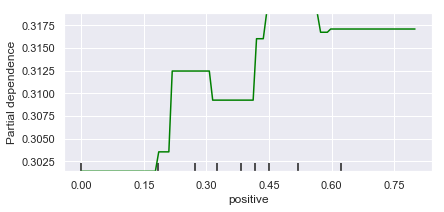

In [72]:
plot_partial_dependence(rf, X, features=[1], 
                        feature_names=X.columns,  
                        target="high", 
                        response_method="predict_proba", 
                        n_jobs=-1) 


In [64]:
my_plots = plot_partial_dependence(rf,       
                                   features=[0, 1, 2], # column numbers of plots we want to show
                                   X=X,            # raw predictors data.
                                   feature_names=['Distance', 'Landsize', 'BuildingArea'], # labels on graphs
                                   grid_resolution=10,
                                   target=y) # number of values to plot on x axis


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()